In [1]:
#This notebook will be a whiteboard for my attempt to replicate
#this paper: https://repository.upenn.edu/cgi/viewcontent.cgi?article=1451&context=statistics_papers
#Our focus will be on zero-sum games/metagames, since thats what most my research entails

#Here will construct our aysmmetric matrix from csv file and map it to our action space
import numpy as np
import csv
np.set_printoptions(precision=3, suppress=True)


#This will be our meta_game action space
action_space = []
file = '2019SummerPR.csv'
#We will survey the csv file to fill our action space
with open(file, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        if row['Player1'] not in action_space:
            action_space.append(row['Player1'])
        
        if row['Player2'] not in action_space:
            action_space.append(row['Player2'])

#Create action_to_index utility dictionary
index = 0
action_to_index = {}
for action in action_space:
    action_to_index[action] = index
    index += 1

#We will generate our dual variables.. intialize them to 0 and attempt to constuct
#a mixed strategy from it
dual_variables = {}
for action_1 in action_space:
    for action_2 in action_space:
        if action_1 is not action_2:
            #Since this is a meta_game, both players cannot select the same strategy (may not apply to all games)
            joint_action = (action_1, action_2)
            dual_variables[joint_action] = 0
        

In [2]:
#Here will construct our aysmmetric matrix from csv file and map it to our action space
import numpy as np
import csv
np.set_printoptions(precision=3, suppress=True)

with open(file, mode='r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    #Create two dictionaries to keep track of wins and losses over matches
    matches = []
    wins_i = {}
    wins_j = {}
    
    for row in csv_reader:
        i = row["Player1"]
        j = row["Player2"]
        match = (i, j)
        matchPrime = (j, i)
        win_i = float(row["Wins"])
        win_j = float(row["Loss"])
        
        if (i in action_space) and (j in action_space):
            if (match in matches) or (matchPrime in matches):
                if match in matches:
                    wins_i[match] += win_i
                    wins_j[match] += win_j
                else:
                    wins_i[matchPrime] += win_j
                    wins_j[matchPrime] += win_i
            else:
                matches.append(match)
                wins_i[match] = win_i
                wins_j[match] = win_j

#Create payoff matrix
M = np.full((len(action_space), len(action_space)), 0.5)
for match, win_i in wins_i.items():
    win_j = wins_j[match]
    payout = win_i/(win_i + win_j)
    print(match, ": ", payout)
    name_i, name_j = match
    
    epsilon = 0.1
    if payout == 0:
        payout += epsilon
    elif payout == 1:
        payout -= epsilon
    
    M[action_to_index[name_i]][action_to_index[name_j]] = payout
    M[action_to_index[name_j]][action_to_index[name_i]] = 1 - payout

#Before logit space
print(M)
#Create logit space
M = np.log(M/(1-M))
print(M)

('Hbox', 'Leffen') :  0.3333333333333333
('Hbox', 'Wizzrobe') :  0.0
('Hbox', 'Mango') :  0.6666666666666666
('Hbox', 'Axe') :  1.0
('Wizzrobe', 'Axe') :  0.25
('Wizzrobe', 'Leffen') :  1.0
('Mango', 'Axe') :  0.6666666666666666
('Mango', 'Leffen') :  0.5
('Mango', 'Wizzrobe') :  1.0
('Axe', 'Leffen') :  0.6666666666666666
('Zain', 'Wizzrobe') :  0.0
('Zain', 'Plup') :  0.25
('Zain', 'Axe') :  0.0
('Zain', 'Mango') :  0.0
('Zain', 'Leffen') :  0.0
('Zain', 'Hbox') :  0.6666666666666666
('Plup', 'Hbox') :  0.0
('Plup', 'Mango') :  0.0
('Plup', 'Wizzrobe') :  1.0
('Plup', 'Leffen') :  0.0
('Plup', 'Axe') :  0.0
('IBDW', 'Hbox') :  0.5
('IBDW', 'Mango') :  0.5
('IBDW', 'Wizzrobe') :  0.0
('IBDW', 'Axe') :  0.0
('IBDW', 'Leffen') :  0.0
('IBDW', 'Plup') :  0.0
('IBDW', 'Zain') :  0.0
('Amsa', 'Wizzrobe') :  0.0
('Amsa', 'Leffen') :  0.0
('Amsa', 'Hbox') :  1.0
('Amsa', 'Zain') :  0.0
('Amsa', 'Mango') :  1.0
('Amsa', 'Axe') :  0.0
('Amsa', 'Plup') :  0.0
('Amsa', 'IBDW') :  0.0
[[0.5   0.3

In [3]:
def payoff(action_1, action_2):
    return M[action_to_index[action_1]][action_to_index[action_2]]

def payoff_gain(alt_action, action, maximum=False, positive=True):
    #Calculate M(alt_action, action') & M(action, action')
    diff = 0 
    for action_prime in action_space:
        if action_prime is not action:
            M_alt = payoff(alt_action, action_prime)
            M_act = payoff(action, action_prime)
            if maximum:     
                if positive:
                    diff += max(0, M_alt - M_act)
                else:
                    diff += max(0, -(M_alt - M_act))
            else: 
                diff += M_alt - M_act
    
    return diff

#Return Z(lambda) of dual variables
def Z(dv):
    sum_one = 0
    for action in action_space:
        sum_two = 0
        for action_prime in action_space:
            if action_prime is not action:
                sum_two += dv[(action,action_prime)] * payoff_gain(action_prime, action)
        sum_one += np.exp(-sum_two)
    return sum_one

#Get mixed strategy from dual variables
def P(dv, a):
    sum_one = 0
    for action_prime in action_space:
        if a != action_prime:
            sum_one += dv[(a,action_prime)]*payoff_gain(action_prime, a)
    
    log_P = -sum_one - np.log(Z(dv))
    return np.exp(log_P)
    

In [4]:
#Test our functions
print(payoff("Wizzrobe", "Hbox"))
print(payoff_gain("Wizzrobe", "Hbox"))
print(P(dual_variables, "Wizzrobe"))

2.1972245773362196
6.1862086239004945
0.11111111111111109


In [5]:
def regret_pos(dv, action, action_prime):
    P_a = P(dv, action)
    final_sum = 0
    for p2_action in action_space:
        P_p2 = P(dv, p2_action)
        p_gain = payoff(action_prime, p2_action) - payoff(action, p2_action)
        
        final_sum += (P_a*P_p2) * max(0, p_gain)
        
    return final_sum
            
def regret_neg(dv, action, action_prime):
    P_a = P(dv, action)
    final_sum = 0
    for p2_action in action_space:
        P_p2 = P(dv, p2_action)
        p_gain = payoff(action_prime, p2_action) - payoff(action, p2_action)
        
        final_sum += (P_a*P_p2) * max(0, -p_gain)
        
    return final_sum

In [6]:
print(regret_pos(dual_variables, "Hbox", "Wizzrobe"))
print(regret_neg(dual_variables, "Hbox", "Wizzrobe"))

0.20699835064782002
0.13062540467373987


In [7]:
def abs_gain(action, action_prime):
    total = 0
    for p2_action in action_space:
        p_gain = abs(payoff(action_prime, p2_action) - payoff(action, p2_action))
        total += p_gain
    
    return total
        
def lower_bound_c():
    bound = 0
    for action in action_space:
        for action_prime in action_space:
            a_gain = abs_gain(action, action_prime)
            if a_gain > bound:
                bound = a_gain
    return bound 

In [8]:
print(abs_gain("Wizzrobe", "Mango"))
print(lower_bound_c())

22.259927845813976
31.048826155158846


In [11]:
from tqdm import tqdm 

def sort_dictionary(d):
    sorted_x = sorted(d.items(), key=lambda kv: kv[1])
    return sorted_x

def plot(dv):
    probs = {}
    for action in action_space:
        probs[action] = P(dv,action)
    
    import matplotlib.pyplot as plt; plt.rcdefaults()
    import numpy as np
    import matplotlib.pyplot as plt

    sort = sort_dictionary(probs)
    #For tier lists
    objects = []
    performance = []
    for player, value in sort:
        objects.append(player)
        performance.append(value)


    y_pos = np.arange(len(objects))
    plt.barh(y_pos, performance, align="center")
    plt.yticks(y_pos, objects)
    plt.xlabel('Density')
    plt.ylabel('Strategies')
    plt.title('Maximum Entropy Nash Distribution')

    plt.show()
    
def log_grad_descent(dv, rounds=10, verbose=True):
    c = lower_bound_c() + 1
    
    for it in tqdm(range(rounds)):
        step_dict = {}
        for action in action_space:
            for action_prime in action_space:
                if action is not action_prime:
                    r_pos = regret_pos(dv, action, action_prime)
                    r_neg = regret_neg(dv, action, action_prime)

                    #print("Joint Action: ", (action, action_prime))
                    #print("r_pos: ", r_pos)
                    #print("r_neg: ", r_neg)
                    
                    term = ((r_pos)/(r_pos + r_neg)) - (1/2)
        
                    
                    step = (1/c)*term
                    
                    step_dict[(action, action_prime)] = max(0, step)
                
        for action in action_space:
            for action_prime in action_space:
                if action is not action_prime:
                    dv[(action, action_prime)] += step_dict[(action, action_prime)]
                
        if verbose:
            print("Iteration ", it)
            plot(dv)

  0%|          | 0/20 [00:00<?, ?it/s]

Iteration  0


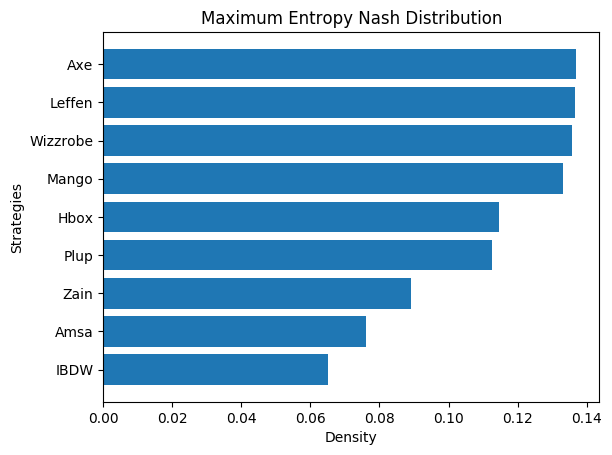

  5%|▌         | 1/20 [00:01<00:30,  1.60s/it]

Iteration  1


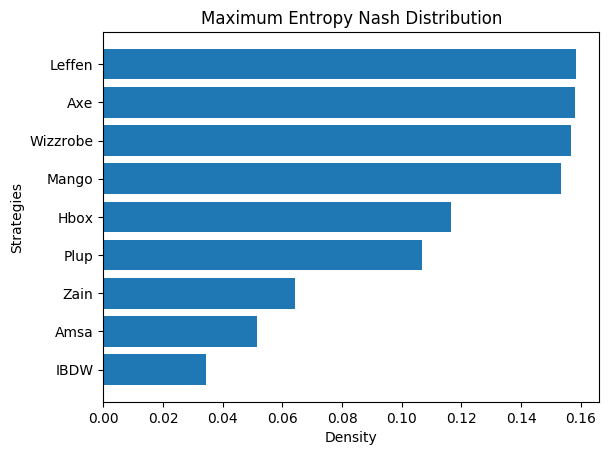

 10%|█         | 2/20 [00:03<00:30,  1.68s/it]

Iteration  2


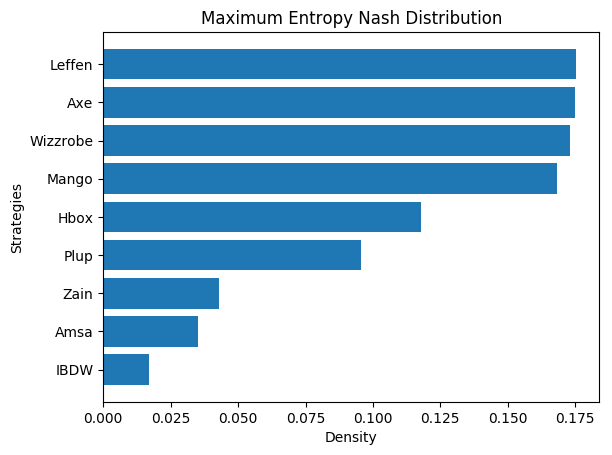

 15%|█▌        | 3/20 [00:05<00:28,  1.69s/it]

Iteration  3


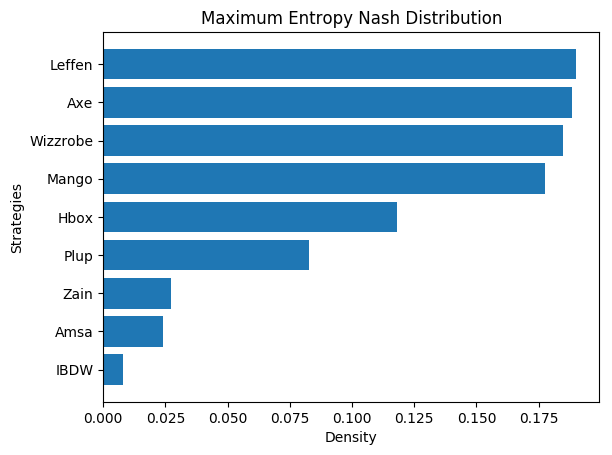

 20%|██        | 4/20 [00:06<00:26,  1.69s/it]

Iteration  4


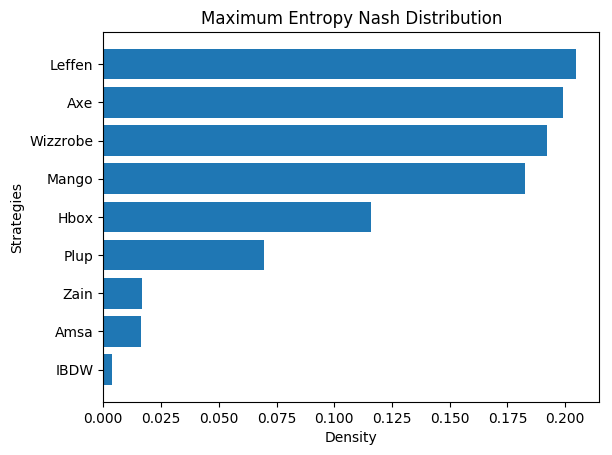

 25%|██▌       | 5/20 [00:08<00:25,  1.73s/it]

Iteration  5


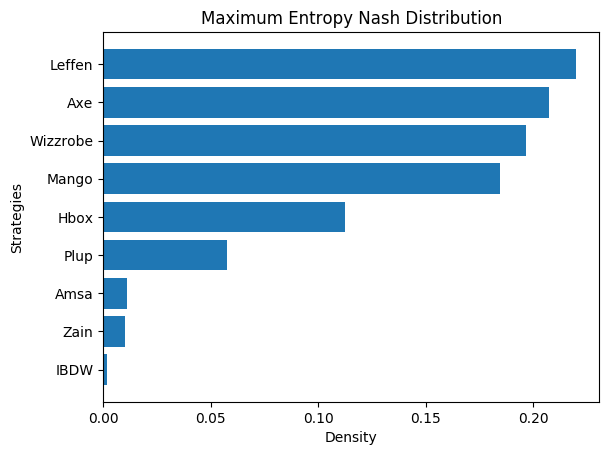

 30%|███       | 6/20 [00:10<00:24,  1.73s/it]

Iteration  6


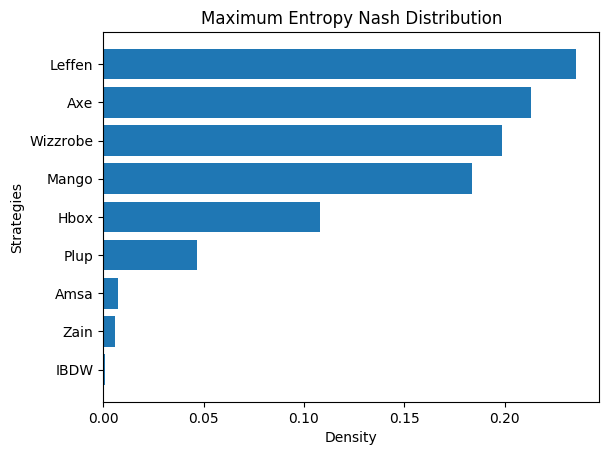

 35%|███▌      | 7/20 [00:12<00:22,  1.76s/it]

Iteration  7


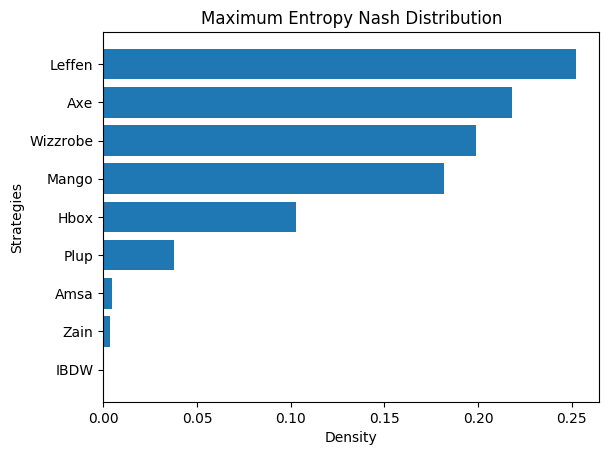

 40%|████      | 8/20 [00:13<00:20,  1.71s/it]

Iteration  8


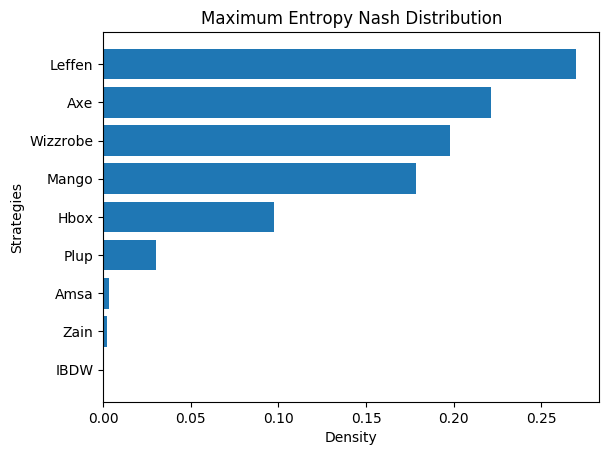

 45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

Iteration  9


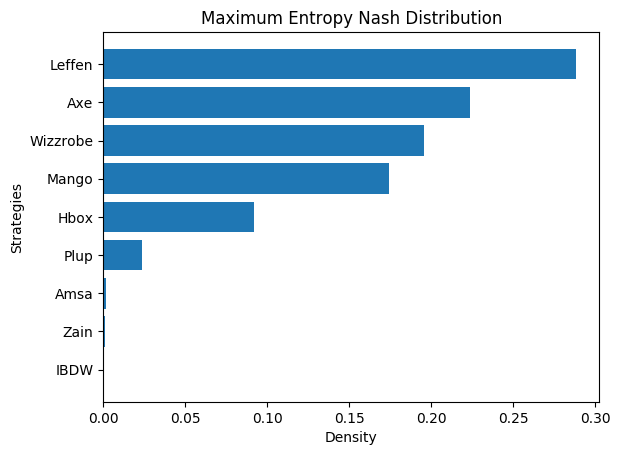

 50%|█████     | 10/20 [00:17<00:16,  1.67s/it]

Iteration  10


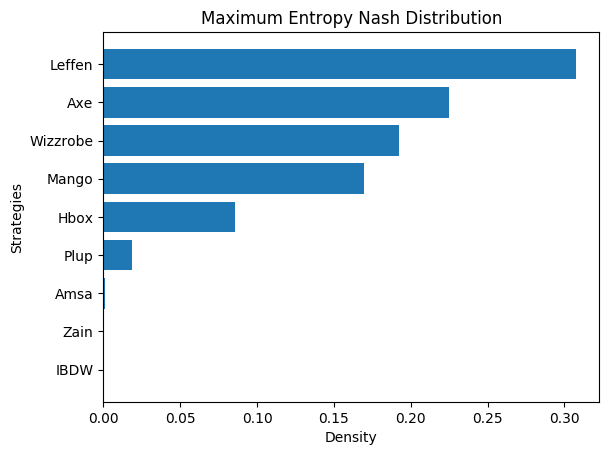

 55%|█████▌    | 11/20 [00:18<00:15,  1.68s/it]

Iteration  11


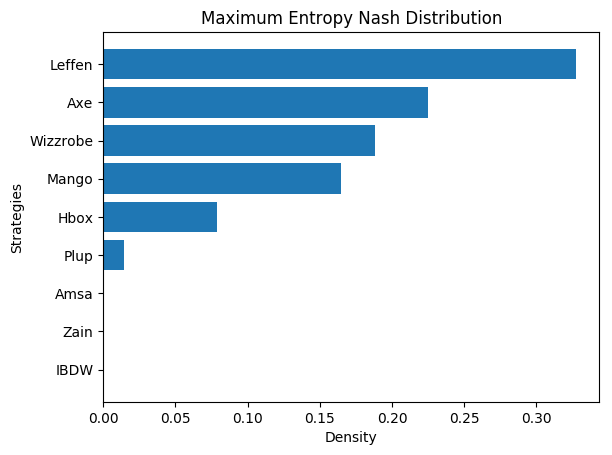

 60%|██████    | 12/20 [00:20<00:13,  1.69s/it]

Iteration  12


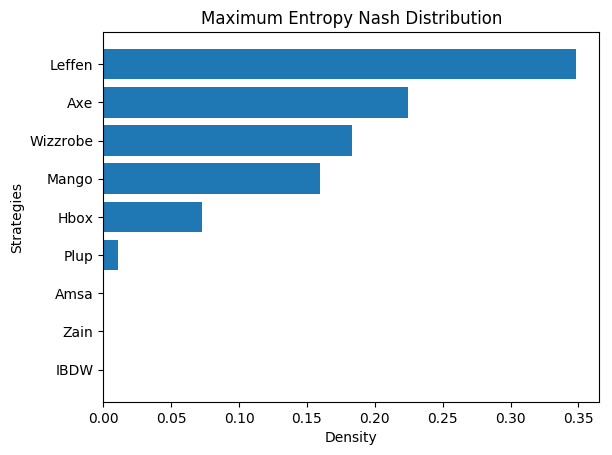

 65%|██████▌   | 13/20 [00:22<00:12,  1.72s/it]

Iteration  13


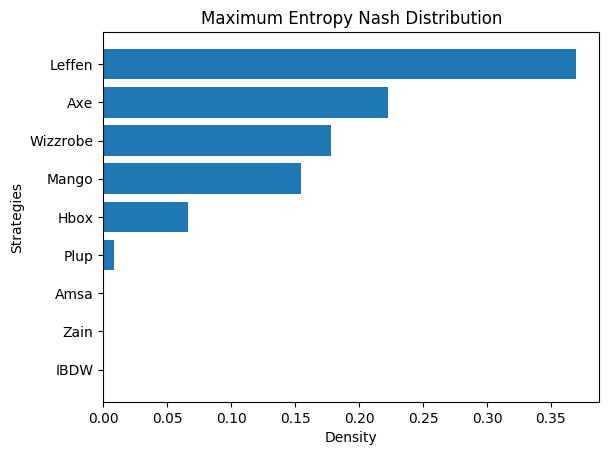

 70%|███████   | 14/20 [00:24<00:10,  1.80s/it]

Iteration  14


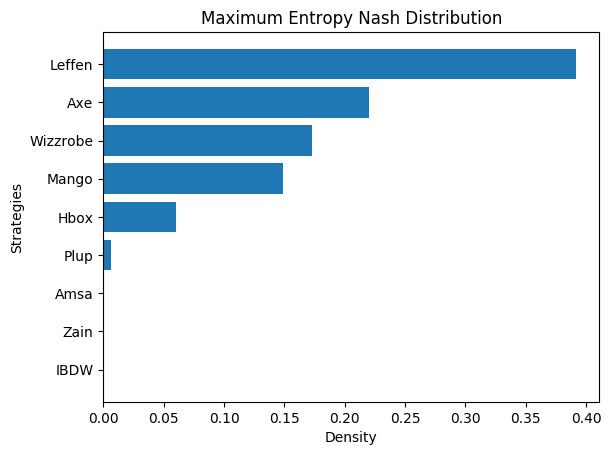

 75%|███████▌  | 15/20 [00:26<00:08,  1.79s/it]

Iteration  15


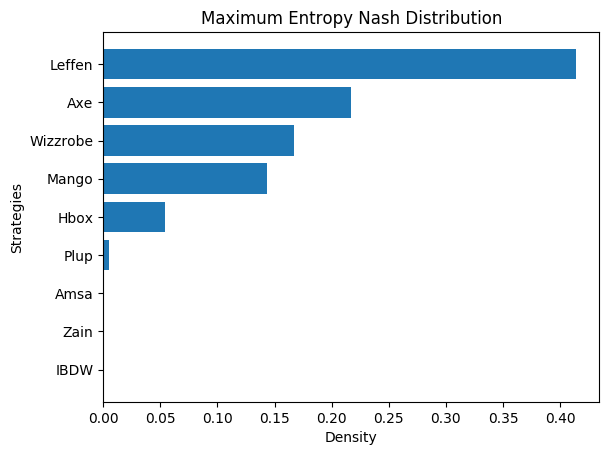

 80%|████████  | 16/20 [00:27<00:06,  1.72s/it]

Iteration  16


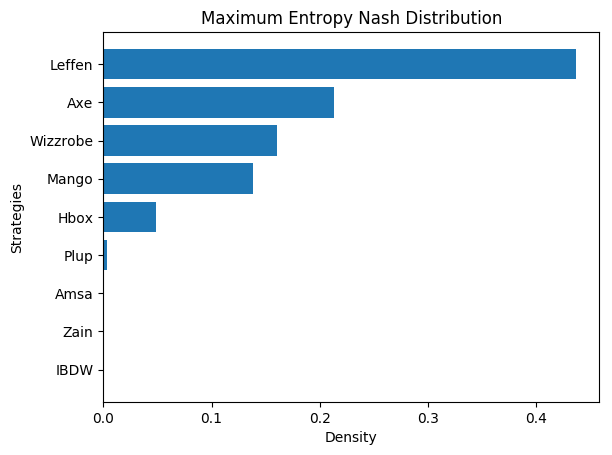

 85%|████████▌ | 17/20 [00:29<00:05,  1.72s/it]

Iteration  17


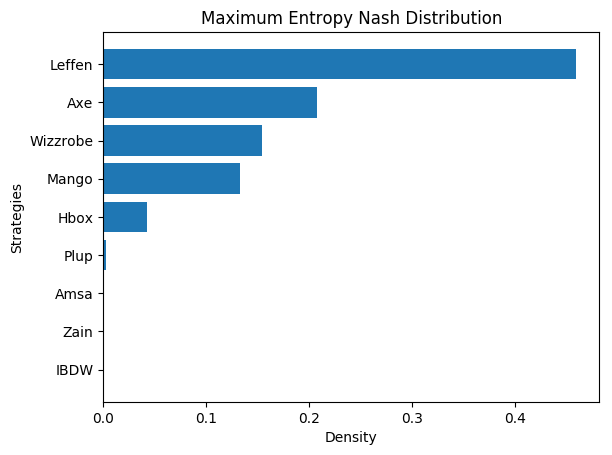

 90%|█████████ | 18/20 [00:31<00:03,  1.71s/it]

Iteration  18


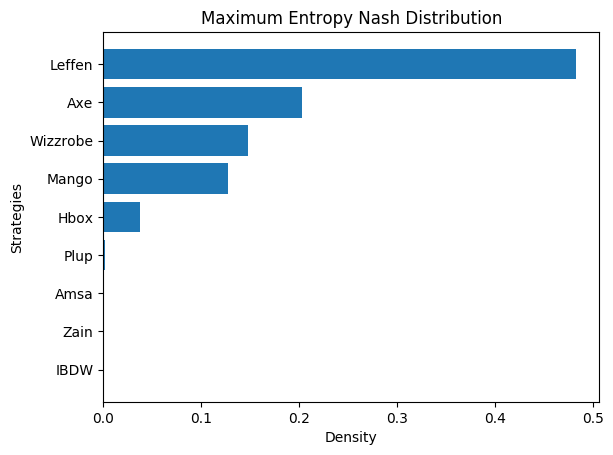

 95%|█████████▌| 19/20 [00:32<00:01,  1.73s/it]

Iteration  19


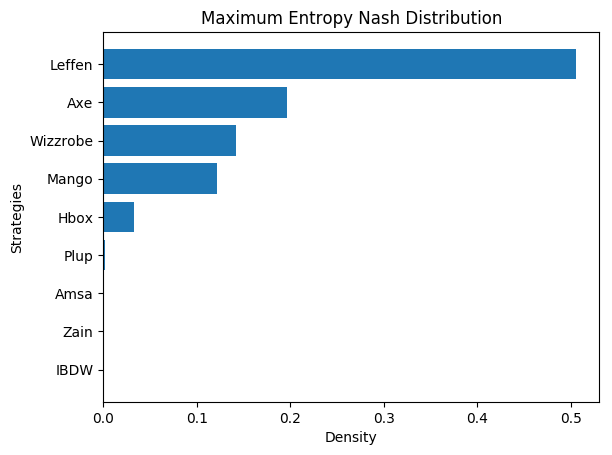

100%|██████████| 20/20 [00:34<00:00,  1.71s/it]


In [12]:
#We will generate our dual variables.. intialize them to 0 and attempt to constuct
#a mixed strategy from it
du = {}

for action_1 in action_space:
    for action_2 in action_space:
        #Since this is a meta_game, both players cannot select the same strategy
        joint = (action_1, action_2)
        du[joint] = 0
        
log_grad_descent(du, verbose=True, rounds=20)

In [13]:
probs = {}
for action in action_space:
    probs[action] = P(du,action)
    print(action, ": ", P(du, action))

Hbox :  0.0330527936635416
Leffen :  0.5051468292879701
Wizzrobe :  0.1420534669539371
Mango :  0.12125041784971505
Axe :  0.19698760193088127
Zain :  3.0106063001051367e-06
Plup :  0.001501122677284989
IBDW :  4.183326547516223e-09
Amsa :  4.7528470432412055e-06


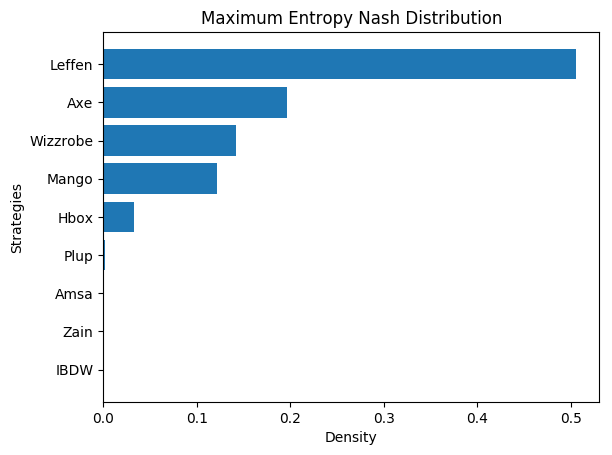

In [16]:
plot(du)